# Colab: Connect Google Drive

In [ ]:
from google.colab import drive

In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/pytorch-multimodal_sarcasm_detection

/content/drive/MyDrive/Colab Notebooks/pytorch-multimodal_sarcasm_detection


# Test .py

In [ ]:
!python LoadData.py

text torch.Size([32, 75]) torch.LongTensor
image feature torch.Size([32, 196, 2048]) torch.FloatTensor
attribute index torch.Size([32, 5]) torch.LongTensor
group tensor([0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 0]) torch.LongTensor
image id tensor([818239030793998336, 818240171359338496, 717398999444156416,
        818607630180581378, 817516728620027904, 822200251281002496,
        903290073726296064, 733740269309399040, 823311984787476481,
        724216630037729280, 822591390160945153, 922790582224797696,
        904519715640360961, 923920542683533312, 818238512642330629,
        820413322059137025, 823316879372591104, 820412330316070912,
        864888540391505924, 821505133884436484, 820409833237217280,
        820055331145252864, 926833664272433152, 689152404487417857,
        877153375783079936, 822950533501743104, 817517435419062272,
        819327505249292292, 822592938941284352, 822590648532533250,
        90260385655

In [ ]:
!python ImageFeature.py

torch.Size([32, 1024])
torch.Size([196, 32, 1024])


In [ ]:
!python AttributeFeature.py

torch.Size([32, 200])
torch.Size([32, 5, 200])


In [ ]:
!python TextFeature.py

torch.Size([32, 512])
torch.Size([32, 75, 512])


In [ ]:
!python FuseAllFeature.py

torch.Size([32, 512])


In [ ]:
!python FinalClassifier.py

torch.Size([32, 1])
tensor([[0.5125],
        [0.5121],
        [0.5114],
        [0.5127],
        [0.5126],
        [0.5124],
        [0.5114],
        [0.5130],
        [0.5122],
        [0.5115],
        [0.5132],
        [0.5116],
        [0.5124],
        [0.5127],
        [0.5129],
        [0.5115],
        [0.5114],
        [0.5123],
        [0.5116],
        [0.5119],
        [0.5124],
        [0.5134],
        [0.5121],
        [0.5115],
        [0.5126],
        [0.5126],
        [0.5118],
        [0.5126],
        [0.5114],
        [0.5121],
        [0.5118],
        [0.5113]], grad_fn=<SigmoidBackward>)
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]

# Train & Test

In [ ]:
import torch
import ImageFeature
import AttributeFeature
import TextFeature
import FinalClassifier
import FuseAllFeature
from LoadData import *
from torch.utils.data import Dataset, DataLoader,random_split
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Multimodel(torch.nn.Module):
    def __init__(self,lstm_dropout_rate,fc_dropout_rate):
        super(Multimodel, self).__init__()
        self.image = ImageFeature.ExtractImageFeature()
        self.attribute = AttributeFeature.ExtractAttributeFeature()
        self.text = TextFeature.ExtractTextFeature(TEXT_LENGTH, TEXT_HIDDEN,lstm_dropout_rate)
        self.fuse = FuseAllFeature.ModalityFusion()
        self.final_classifier = FinalClassifier.ClassificationLayer(fc_dropout_rate)
    def forward(self, text_index, image_feature, attribute_index):
        image_result,image_seq = self.image(image_feature)
        attribute_result,attribute_seq = self.attribute(attribute_index)
        text_result,text_seq = self.text(text_index,attribute_result)
        fusion = self.fuse(image_result,image_seq,text_result,text_seq.permute(1,0,2),attribute_result,attribute_seq.permute(1,0,2))
        output = self.final_classifier(fusion)
        return output

In [ ]:
def train(model,train_loader,val_loader,loss_fn,optimizer,number_of_epoch):
    for epoch in range(number_of_epoch):
        train_loss=0
        correct_train=0
        model.train()
        for text_index, image_feature, attribute_index, group, id in train_loader:
            group = group.view(-1,1).to(torch.float32).to(device)
            pred = model(text_index.to(device), image_feature.to(device), attribute_index.to(device))
            loss = loss_fn(pred, group)
            train_loss+=loss
            correct_train+=(pred.round()==group).sum().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calculate valid loss

        valid_loss=0
        correct_valid=0
        model.eval()
        with torch.no_grad():
            for val_text_index, val_image_feature, val_attribute_index, val_group, val_id in val_loader:
                val_group = val_group.view(-1,1).to(torch.float32).to(device)
                val_pred = model(val_text_index.to(device), val_image_feature.to(device), val_attribute_index.to(device))
                val_loss = loss_fn(val_pred, val_group)
                valid_loss+=val_loss
                correct_valid+=(val_pred.round()==val_group).sum().item()

        print("epoch: %d train_loss=%.5f train_acc=%.3f valid_loss=%.5f valid_acc=%.3f"%(epoch,
                                                                                         train_loss/len(train_loader),
                                                                                      correct_train/len(train_loader)/batch_size,
                                                                                         valid_loss/len(val_loader),
                                                                                         correct_valid/len(val_loader)/batch_size))
                           

In [ ]:
learning_rate_list = [0.001]
fc_dropout_rate_list=[0,0.3,0.9,0.99]
lstm_dropout_rate_list=[0, 0.2, 0.4]
weight_decay_list=[0,1e-6,1e-5,1e-4]
# weight_decay_list=[1e-7]
batch_size=32
data_shuffle=False

In [ ]:
train_fraction=0.8
val_fraction=0.1
train_loader = DataLoader(train_set,batch_size=batch_size, shuffle=data_shuffle)
val_loader = DataLoader(val_set,batch_size=batch_size, shuffle=data_shuffle)
test_loader = DataLoader(test_set,batch_size=batch_size, shuffle=data_shuffle)
play_loader = DataLoader(test_set,batch_size=1, shuffle=data_shuffle)

In [ ]:
import itertools
comb = itertools.product(learning_rate_list, fc_dropout_rate_list,lstm_dropout_rate_list,weight_decay_list)

In [ ]:
for learning_rate, fc_dropout_rate,lstm_dropout_rate,weight_decay in list(comb):
    print(f"learning rate={learning_rate} | fc dropout={fc_dropout_rate} | lstm dropout={lstm_dropout_rate} | weight decay={weight_decay}")
    # loss function
    loss_fn=torch.nn.BCELoss()
    # initilize the model
    model = Multimodel(lstm_dropout_rate,fc_dropout_rate).to(device)
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    # train
    number_of_epoch=7
    train(model,train_loader,val_loader,loss_fn,optimizer,number_of_epoch)

learning rate=0.001 | fc dropout=0 | lstm dropout=0 | weight decay=0


KeyboardInterrupt: ignored

In [ ]:
import sklearn.metrics as metrics
import seaborn as sns

In [ ]:
def validation_metrics (model, dataset):
    model.eval()
    with torch.no_grad():
        correct=0
        confusion_matrix_sum=None
        loss_sum=0
        for text_index, image_feature, attribute_index, group, id in dataset:
            group = group.view(-1,1).to(torch.float32).to(device)
            pred = model(text_index.to(device), image_feature.to(device), attribute_index.to(device))
            loss = loss_fn(pred, group)
            loss_sum+=loss
            correct+=(pred.round()==group).sum().item()
            # calculate confusion matrix
            if confusion_matrix_sum is None:
                confusion_matrix_sum=metrics.confusion_matrix(group.to("cpu"),pred.round().to("cpu"),labels=[0,1])
            else:
                confusion_matrix_sum+=metrics.confusion_matrix(group.to("cpu"),pred.round().to("cpu"),labels=[0,1])
        acc=correct/len(dataset)/batch_size
        loss_avg=loss_sum/len(dataset)
    return loss_avg.item(), acc, confusion_matrix_sum

In [ ]:
def plot_confusion_matrix(confusion_matrix):
    emotions=['not sarcasm','sarcasm']
    sns.heatmap(confusion_matrix, annot=True, xticklabels=emotions, yticklabels=emotions, fmt='g')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
loss, acc, confusion_matrix=validation_metrics (model, test_loader)

In [ ]:
print("loss:",loss,"accuracy:",acc)

In [ ]:
plot_confusion_matrix(confusion_matrix)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def validation_metrics (model, dataset):
    model.eval()
    with torch.no_grad():
        count=0
        for text_index, image_feature, attribute_index, group, id in dataset:
            if count==5:
                break
            id=id.item()
            print(f">>>Example {count+1}<<<")
            img=all_Data.image_loader(id)
            plt.imshow(img.permute(1,2,0))
            plt.show()
            print("Text: ",all_Data.text_loader(id))
            print("Labels: ",all_Data.label_loader(id))
            print(f"Truth:{' not ' if group[0]==0 else ' '}sarcasm")
            pred = model(text_index.to(device), image_feature.to(device), attribute_index.to(device))
            print(f"Predict:{' not ' if round(pred[0,0].item())==0 else ' '}sarcasm")
            count+=1

>>>Example 1<<<


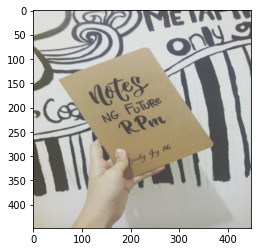

Text:  as we all know , calligraphy is one of the artsy-trendy ! grab a personalized notebook and get yours for only php 50
Labels:  ['sign', 'painted', 'sand', 'says', 'bed']
Truth: not sarcasm
Preduct: not sarcasm
>>>Example 2<<<


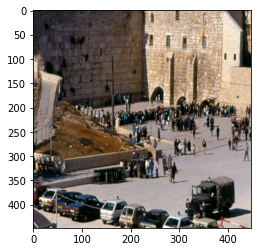

Text:  i will not remain silent . israel and the temple mount belong to the jews . <user> <user> <user>
Labels:  ['building', 'large', 'parked', 'people', 'landing']
Truth: not sarcasm
Preduct: not sarcasm
>>>Example 3<<<


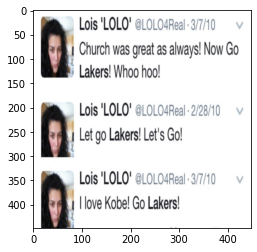

Text:  today 's winner of the kia : bandwagon fan of the day award , <user> ! # warriorsbandwagon emoji_1031
Labels:  ['happy', 'bun', 'phone', 'bathroom', 'cellphone']
Truth: not sarcasm
Preduct: not sarcasm
>>>Example 4<<<


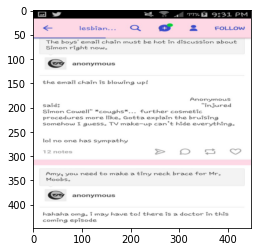

Text:  larries out here living the treat people with kindness life . # eyeroll 
Labels:  ['picture', 'birds', 'perched', 'screen', 'showing']
Truth: sarcasm
Preduct: sarcasm
>>>Example 5<<<


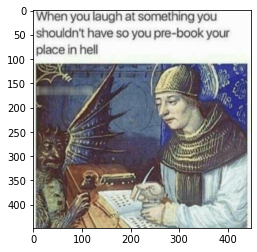

Text:  the saying of " i 'm going to hell for this or laughing at this " is quite often . # myhumorisdark  # andbeing # savage is part of me now
Labels:  ['painting', 'old', 'picture', 'photo', 'woman']
Truth: sarcasm
Preduct: sarcasm


In [ ]:
validation_metrics (model, play_loader)